In [1356]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import pandas as pd
import statsmodels.api as sm

from statsmodels.regression.rolling import RollingOLS
from joblib import Parallel, delayed
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from matplotlib.backends.backend_svg import FigureCanvasSVG


from functions.utils.system import *
from functions.utils.func import *
from prep_factor import PrepFactor 

import warnings

warnings.filterwarnings('ignore')

In [1357]:
live = True
stock = read_stock(get_large_dir(live) / 'permno_live.csv')
start = '2005-01-01'
window = 12
current_date = (date.today()).strftime('%Y-%m-%d')

# Calculate S Score

In [1358]:
factor_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
risk_free = pd.read_parquet(get_parquet_dir(live) / 'data_rf.parquet.brotli')

# Read in live market data
sector_df = get_data_fmp(ticker_list=['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU'], start=start, current_date=current_date)
T = [1]
sector_df = sector_df[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_df = sector_df.rename(columns={'Adj Close': 'Close'})

sector_df = create_return(sector_df, T)
sector_df = sector_df.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_df = sector_df.unstack('ticker').swaplevel(axis=1)
sector_df.columns = ['_'.join(col).strip() for col in sector_df.columns.values]

sector_data = sector_df
sector_data = pd.concat([sector_data, risk_free['RF']], axis=1)
sector_data = sector_data.loc[start:current_date]
sector_data = sector_data.fillna(0)
factor_col = sector_data.columns[:-1]

Fetching data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.61s/ticker]


In [1359]:
T = [1]
factor_data = create_return(factor_data, T)
factor_data = factor_data.fillna(0)

In [1360]:
for t in T:
    ret = f'RET_01'
    # if window size is too big it can create an index out of bound error (took me 3 hours to debug this error!!!)
    etf = rolling_ols_parallel(data=factor_data, ret=ret, factor_data=sector_data, factor_cols=factor_col.tolist(), window=window, name=f'sector_{t:02}')

In [1361]:
etf.columns

Index(['ALPHA_sector_01_12', 'XLB_RET_01_sector_01_12',
       'XLE_RET_01_sector_01_12', 'XLF_RET_01_sector_01_12',
       'XLI_RET_01_sector_01_12', 'XLK_RET_01_sector_01_12',
       'XLP_RET_01_sector_01_12', 'XLU_RET_01_sector_01_12',
       'XLV_RET_01_sector_01_12', 'XLY_RET_01_sector_01_12',
       'epsil_sector_01_12', 'pred_sector_01_12', 'resid_mom_21_sector_01_12',
       'resid_mom_126_sector_01_12', 'idio_vol_21_sector_01_12',
       'idio_vol_126_sector_01_12'],
      dtype='object')

In [1362]:
etf = etf[etf.columns[1:11]]

In [1363]:
etf['Xk'] = etf[f'epsil_sector_01_{window:02}'].rolling(21).sum()
etf['Xk_lag'] = etf['Xk'].groupby('permno').shift(-1)
etf['Xk_diff'] = etf['Xk'].groupby('permno').diff()
etf = etf.fillna(0)

In [1364]:
def process_stock(stock_data, ret, factor_col, window, stock_name, index_name):
    model_data = stock_data[[ret, factor_col]].fillna(0)
    rolling_ols = RollingOLS(endog=model_data[ret], exog=sm.add_constant(model_data[factor_col]), window=window)
    factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const': 'ALPHA'})
    result = factor_model.assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
    return result

def compute_betas_parallel(etf, ret='Xk_diff', factor_col='Xk_lag', window=window, name='ss'):
    tasks = [(group, ret, factor_col, window, stock, etf.index.names[0]) for stock, group in etf.groupby(etf.index.names[0])]
    results = Parallel(n_jobs=-1)(delayed(process_stock)(*task) for task in tasks)
    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

betas = compute_betas_parallel(etf).droplevel(0)

In [1365]:
betas.columns

Index(['ALPHA_ss_12', 'Xk_lag_ss_12'], dtype='object')

In [1366]:
group = betas.copy(deep=True)
group.columns = ['a', 'b']
group = group.merge(etf[['Xk_diff', 'Xk_lag']], left_index=True, right_index=True, how='left')

In [1367]:
group['kappa'] = -np.log(group['b']) * 252
group['m'] = group['a'] / (1 - group['b'])
group['sigma'] = np.sqrt(group['Xk_diff'].var() * 2 * group['kappa'] / (1 - group['b']**2))
group['sigma_eq'] = np.sqrt(group['Xk_diff'].var() / (1 - group['b']**2))
group['s_score'] = -group['m'] / group['sigma_eq']

mean_a = group['a'].mean()
group['m'] = mean_a / (1 - group['b'])
group['s_score_centered'] = (-group['a'] * np.sqrt(1 - group['b']**2) / (1 - group['b']) * np.sqrt(group['Xk_diff'].var()) + mean_a / (1 - group['b']) * np.sqrt(group['Xk_diff'].var())) / group['sigma_eq']

# Backtest

In [1368]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['permno', 'date'])
    return multi_index_factor

sector_multi = create_multi_index(sector_df, stock)

In [1369]:
combined = group[['s_score']].merge(etf, left_index=True, right_index=True, how='left')
combined = combined.merge(sector_multi, left_index=True, right_index=True, how='left')
combined = combined.merge(factor_data[['RET_01']], left_index=True, right_index=True, how='left')
combined = combined.fillna(0)

In [1370]:
combined.columns

Index(['s_score', 'XLB_RET_01_sector_01_12', 'XLE_RET_01_sector_01_12',
       'XLF_RET_01_sector_01_12', 'XLI_RET_01_sector_01_12',
       'XLK_RET_01_sector_01_12', 'XLP_RET_01_sector_01_12',
       'XLU_RET_01_sector_01_12', 'XLV_RET_01_sector_01_12',
       'XLY_RET_01_sector_01_12', 'epsil_sector_01_12', 'Xk', 'Xk_lag',
       'Xk_diff', 'XLB_RET_01', 'XLE_RET_01', 'XLF_RET_01', 'XLI_RET_01',
       'XLK_RET_01', 'XLP_RET_01', 'XLU_RET_01', 'XLV_RET_01', 'XLY_RET_01',
       'RET_01'],
      dtype='object')

In [1371]:
combined = combined[['s_score', 'RET_01',
                     f'XLB_RET_01_sector_01_{window:02}',
                     f'XLE_RET_01_sector_01_{window:02}',
                     f'XLP_RET_01_sector_01_{window:02}',
                     f'XLU_RET_01_sector_01_{window:02}',
                     f'XLV_RET_01_sector_01_{window:02}',
                     f'XLY_RET_01_sector_01_{window:02}',
                     'XLB_RET_01','XLE_RET_01', 'XLF_RET_01', 'XLI_RET_01', 
                     'XLK_RET_01', 'XLP_RET_01', 'XLU_RET_01', 'XLV_RET_01', 'XLY_RET_01']]
# combined[['RET_01', 'XLB_RET_01','XLE_RET_01', 'XLF_RET_01', 'XLI_RET_01', 
# 'XLK_RET_01', 'XLP_RET_01', 'XLU_RET_01', 'XLV_RET_01', 'XLY_RET_01']] = combined.groupby('permno')[['RET_01', 'XLB_RET_01','XLE_RET_01', 'XLF_RET_01', 'XLI_RET_01', 
# 'XLK_RET_01', 'XLP_RET_01', 'XLU_RET_01', 'XLV_RET_01', 'XLY_RET_01']].shift(1)

In [1372]:
def compute_trading_signal(data, sbo, sso, sbc, ssc):
    def apply_rules(group):
        position = None
        signals = []

        for s_score in group['s_score']:
            if position is None:
                if s_score < -sbo:
                    position = 'buy'
                    signals.append('buy to open')
                elif s_score > sso:
                    position = 'sell'
                    signals.append('sell to open')
                else:
                    signals.append(None)
            elif position == 'buy':
                if s_score > -ssc:
                    position = None
                    signals.append('close long')
                else:
                    signals.append('hold')
            elif position == 'sell':
                if s_score < sbc:
                    position = None
                    signals.append('close short')
                else:
                    signals.append('hold')
            else:
                signals.append(None)

        return pd.Series(signals, index=group.index)

    # Sort data by permno and date for consistency
    data = data.sort_values(by=['permno', 'date'])
    # Group by permno and apply the rules for each group
    data['signal'] = data.groupby('permno').apply(lambda x: apply_rules(x)).reset_index(level=0, drop=True)
    return data

In [1373]:
sbo = -0.05
sso = -1.25
sbc = 1.5
ssc = 0.09
result = compute_trading_signal(combined, sbo, sso, sbc, ssc)

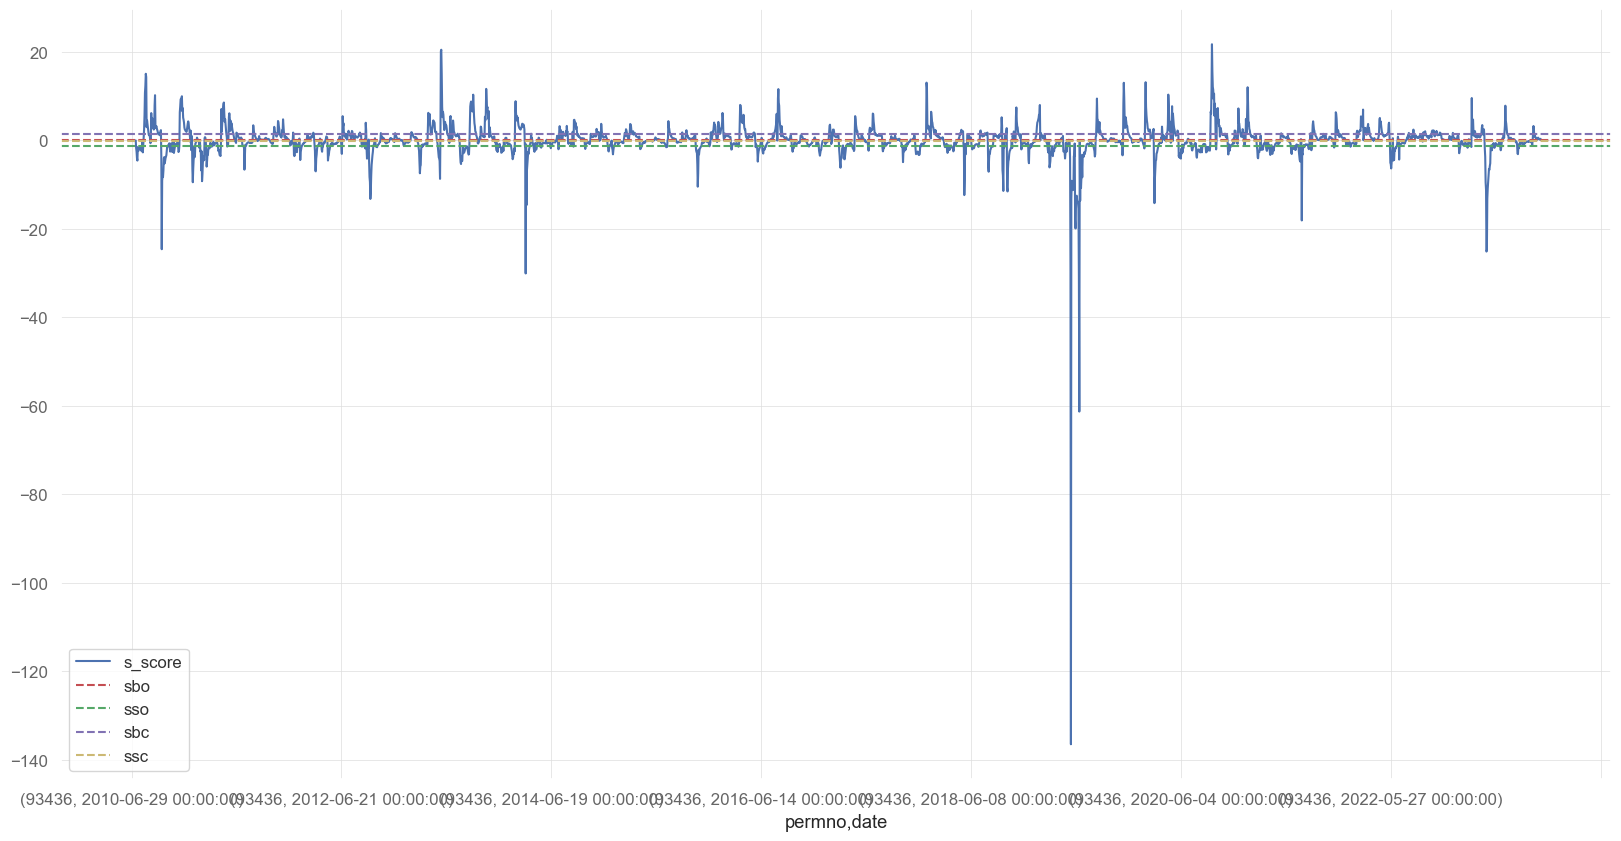

In [1374]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 10))
# Plot the s_score
get_stock_data(combined, 93436).s_score.plot(ax=ax)
# Plot the threshold lines
ax.axhline(y=-sbo, color='r', linestyle='--', label='sbo')
ax.axhline(y=sso, color='g', linestyle='--', label='sso')
ax.axhline(y=sbc, color='m', linestyle='--', label='sbc')
ax.axhline(y=-ssc, color='y', linestyle='--', label='ssc')
# Add legend
ax.legend()
# Display the plot
plt.show()

In [1375]:
def compute_portfolio_returns(df):
    # Map signal to its corresponding position
    position_map = {
        'buy to open': 'long',
        'sell to open': 'short',
        'close long': 'close long',
        'close short': 'close short'
    }
    
    # Create a 'position' column based on 'signal' column
    df['position'] = df['signal'].map(position_map)
    
    # Forward fill the long/short positions until a close signal
    df['position'] = df['position'].where(df['position'].str.contains('close'), df['position'].ffill())
    
    # Create a shifted position column to identify the initial signals
    df['shifted_position'] = df['position'].shift(1)
    
    # Extract all beta columns and compute the cumulative hedge return
    beta_columns = [col for col in df.columns if '_sector_' in col]
    hedge_return = sum(df[beta] * df[beta.split('_sector_')[0].replace('_sector_', '')] for beta in beta_columns)

    # Create conditions
    long_condition = df['position'] == 'long'
    short_condition = df['position'] == 'short'
    close_long_condition = df['position'] == 'close long'
    close_short_condition = df['position'] == 'close short'
    initial_long_condition = (df['position'] == 'long') & (df['shifted_position'] != 'long')
    initial_short_condition = (df['position'] == 'short') & (df['shifted_position'] != 'short')
    
    # Compute portfolio returns
    df['portfolio_return'] = np.where(initial_long_condition | initial_short_condition, 0,
                                      np.where(long_condition, df['RET_01'] - hedge_return, 
                                               np.where(short_condition, -df['RET_01'] + hedge_return, 
                                                        np.where(close_long_condition, df['RET_01'] - hedge_return, 
                                                                 np.where(close_short_condition, -df['RET_01'] + hedge_return, 0)))))

    # Clean up the helper columns
    df.drop(['position', 'shifted_position'], axis=1, inplace=True)
    return df['portfolio_return']

In [1376]:
result['portfolio_return'] = result.groupby(level=0).apply(compute_portfolio_returns).reset_index(level=0, drop=True)

In [1377]:
def validate_signals(signals):
    buy_to_open_count = signals[signals == 'buy to open'].count()
    close_long_count = signals[signals == 'close long'].count()
    sell_to_open_count = signals[signals == 'sell to open'].count()
    close_short_count = signals[signals == 'close short'].count()
    if buy_to_open_count != close_long_count:
        return f"Buy to Open: {buy_to_open_count}, Close Long: {close_long_count}"
    if sell_to_open_count != close_short_count:
        return f"Sell to Open: {sell_to_open_count}, Close Short: {close_short_count}"
    return "Balanced"

In [1378]:
signal_counts = result.groupby(level=0)['signal'].apply(validate_signals)
imbalanced_signals = signal_counts[signal_counts != "Balanced"]
print(imbalanced_signals)

permno
10078        Buy to Open: 82, Close Long: 81
10104      Buy to Open: 366, Close Long: 365
10107      Buy to Open: 369, Close Long: 368
10137    Sell to Open: 326, Close Short: 325
10138    Sell to Open: 996, Close Short: 995
                        ...                 
93223    Sell to Open: 321, Close Short: 320
93246      Buy to Open: 195, Close Long: 194
93296      Buy to Open: 227, Close Long: 226
93429      Buy to Open: 209, Close Long: 208
93436    Sell to Open: 575, Close Short: 574
Name: signal, Length: 622, dtype: object


In [1379]:
# Get the first date of each year
first_dates_per_year = result.reset_index().groupby(result.index.get_level_values('date').year)['date'].first()

# Map these first dates to the number of stocks at the beginning of the year
stocks_count_dict = {date: len(get_stock_idx(set_timeframe(result, str(date.year), str(date.year + 1)))) for date in first_dates_per_year}

# Use the map function to quickly assign the number of stocks for each date
result['num_stocks_start_year'] = result.index.get_level_values('date').map(stocks_count_dict)
result['num_stocks_start_year'] = result['num_stocks_start_year'].ffill()

result['weight'] = 1 / result['num_stocks_start_year']
result['weighted_portfolio_return'] = result['weight'] * result['portfolio_return']
daily_portfolio_return = result.groupby(level=1)['weighted_portfolio_return'].sum()

## Plot

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-01-04   2005-01-04
End Period                 2023-10-30   2023-10-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          245.46%      1,680.14%
CAGR﹪                     4.65%        11.13%

Sharpe                     0.44         2.14
Prob. Sharpe Ratio         97.06%       100.0%
Smart Sharpe               0.43         2.1
Sortino                    0.61         3.85
Smart Sortino              0.6          3.78
Sortino/√2                 0.43         2.72
Smart Sortino/√2           0.42         2.67
Omega                      1.69         1.69

Max Drawdown               -56.47%      -8.0%
Longest DD Days            1982         186
Volatility (ann.)          19.42%       7.28%
R^2                        0.07         0.07
Information Ratio          0.02         0.02
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-10-01,2020-03-26,2020-04-03,186,-7.997047,-6.990978
2,2009-01-07,2009-02-03,2009-03-09,62,-7.340974,-7.252204
3,2016-05-10,2016-06-27,2016-06-30,52,-6.595899,-4.088672
4,2011-09-19,2011-09-22,2011-10-26,38,-6.175885,-5.845854
5,2023-03-29,2023-05-10,2023-06-05,69,-4.878318,-4.861515


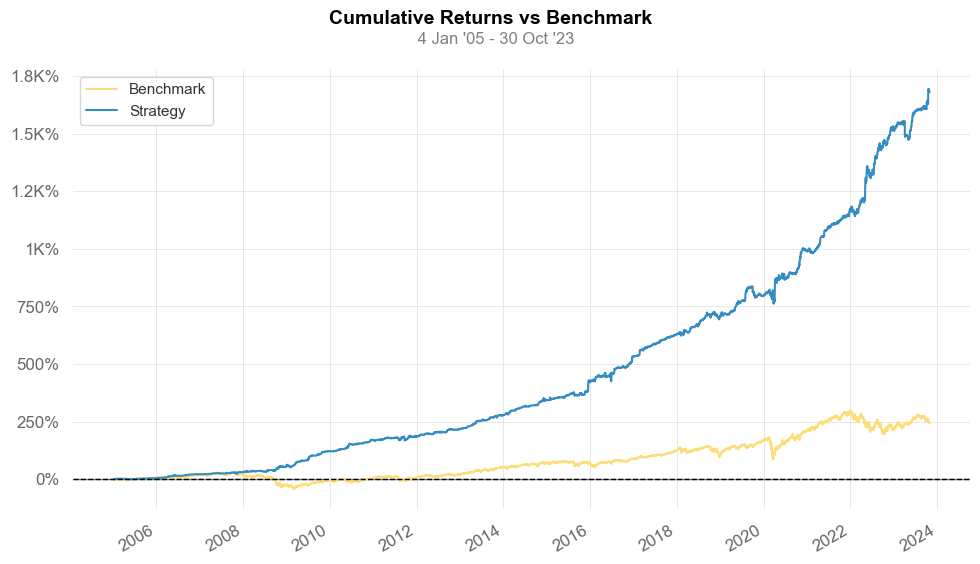

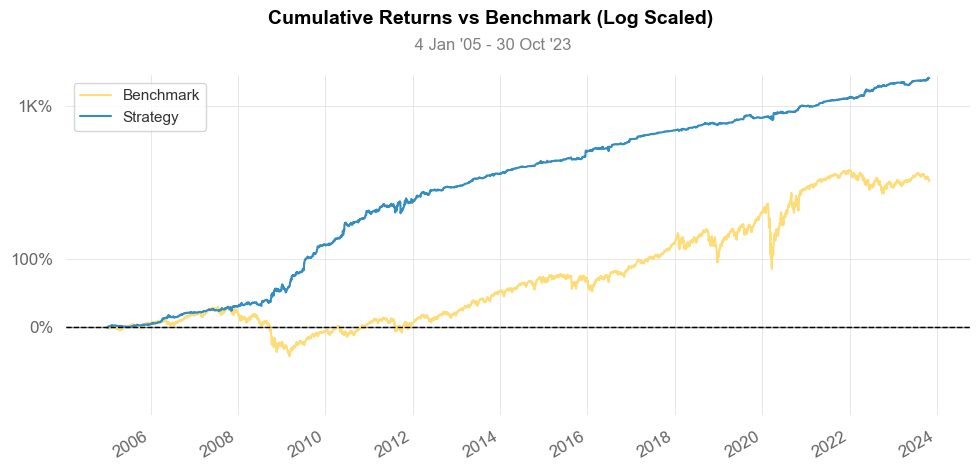

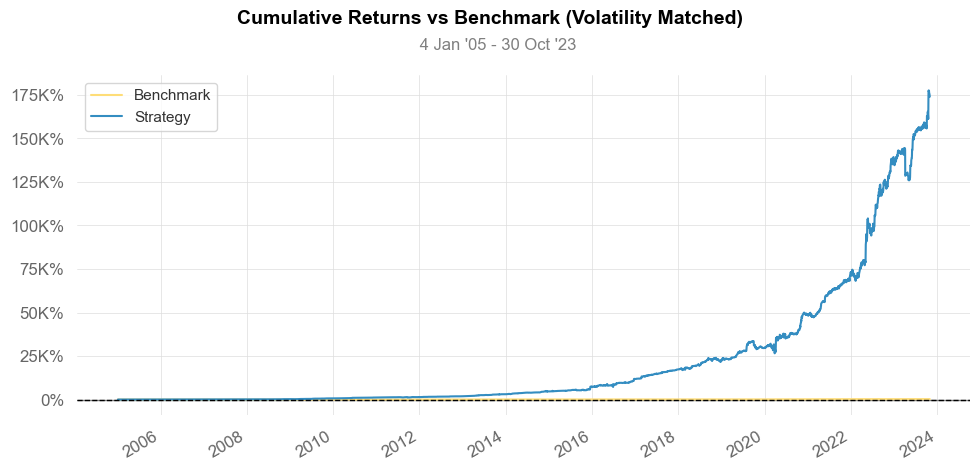

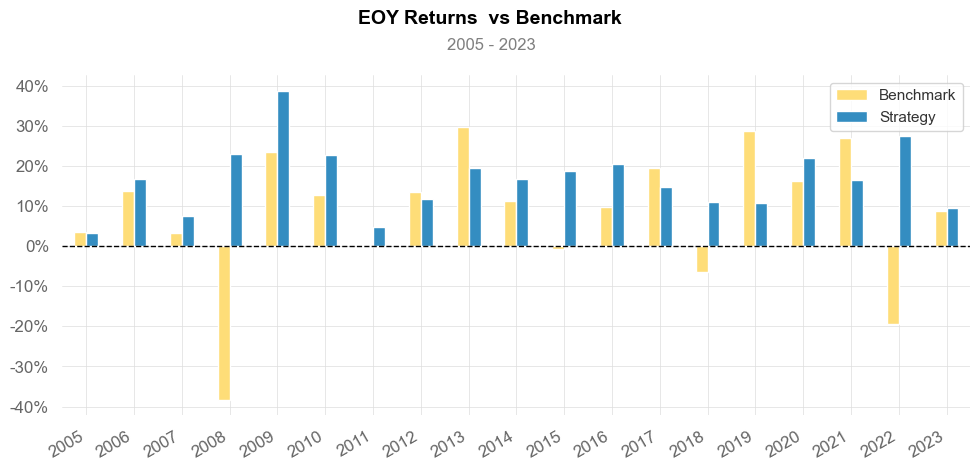

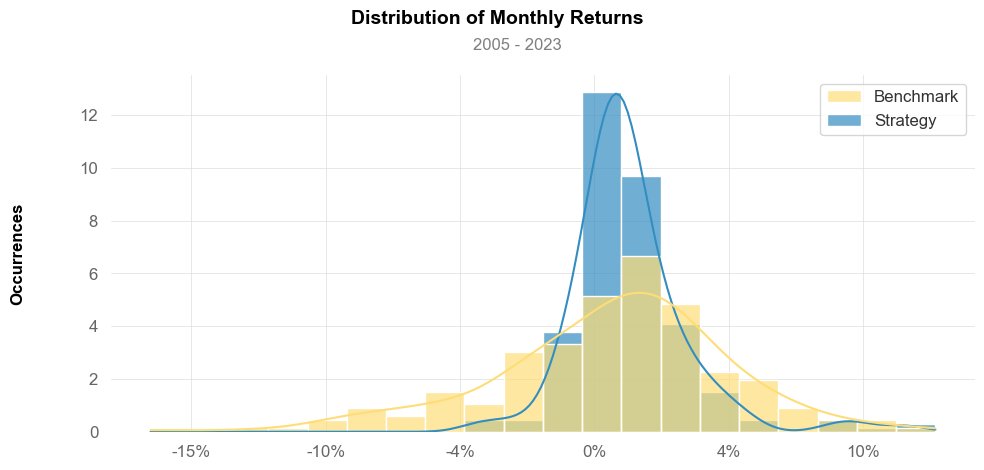

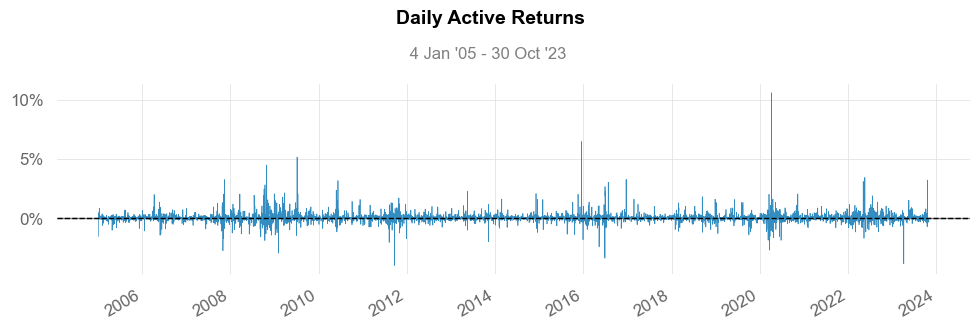

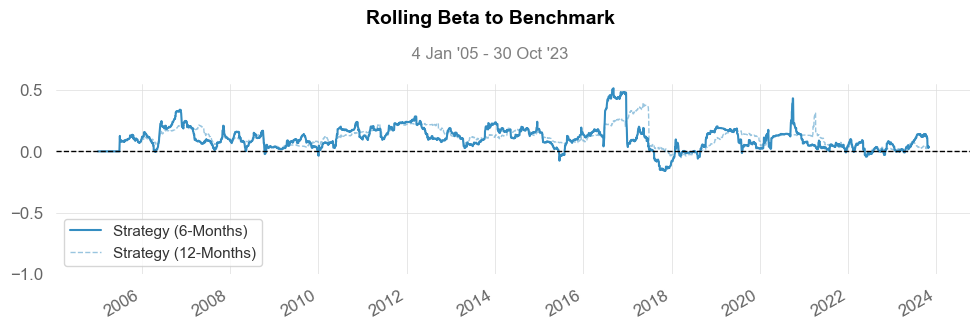

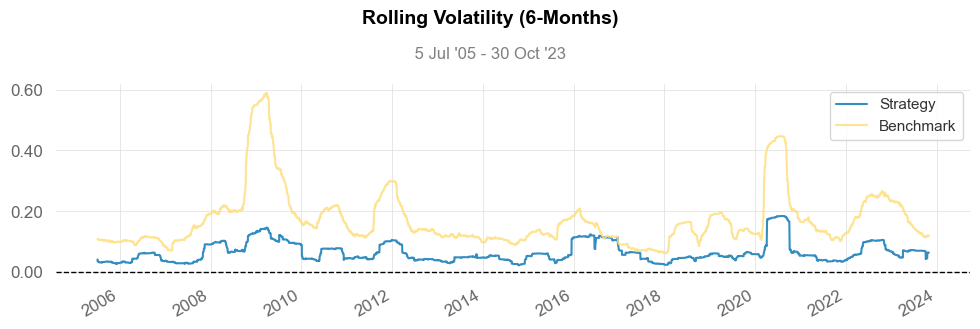

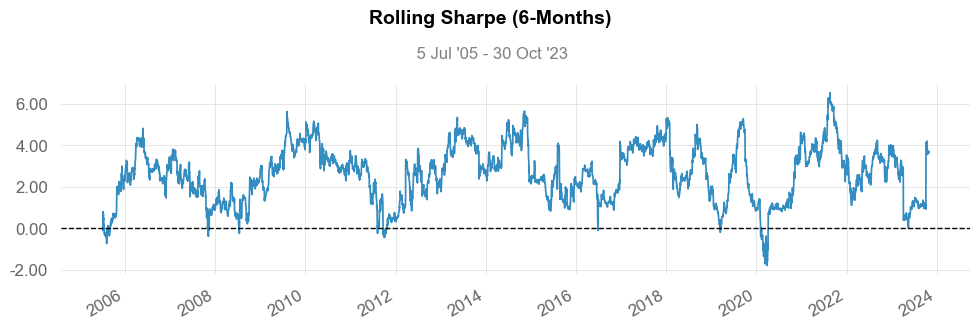

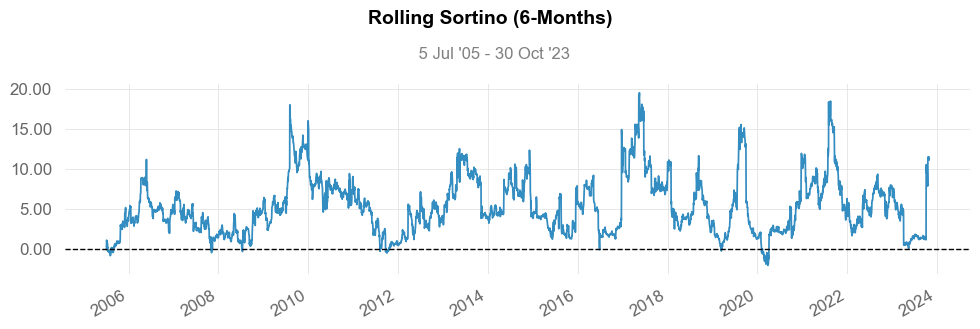

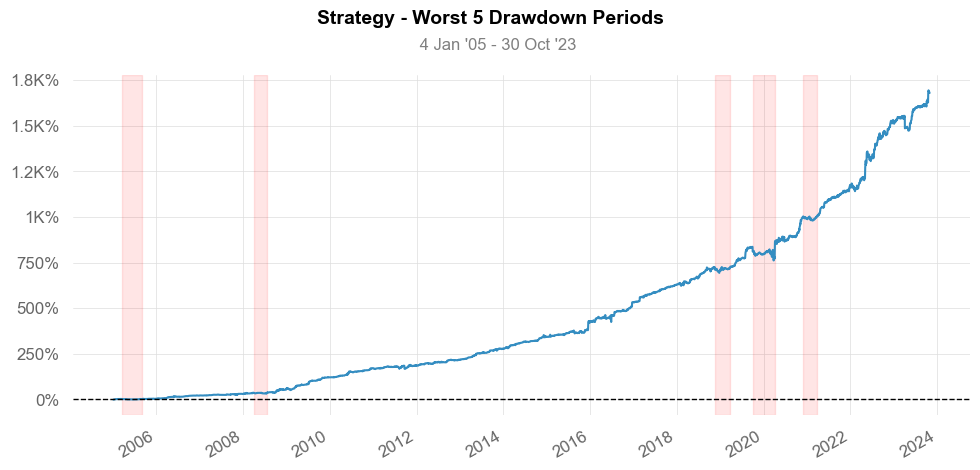

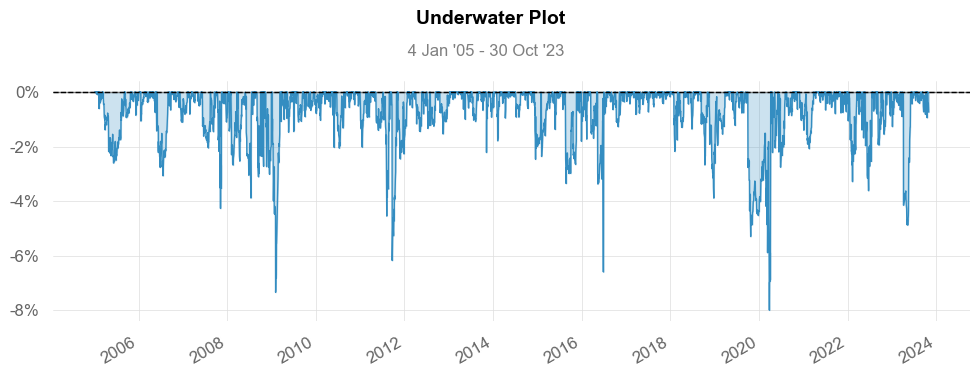

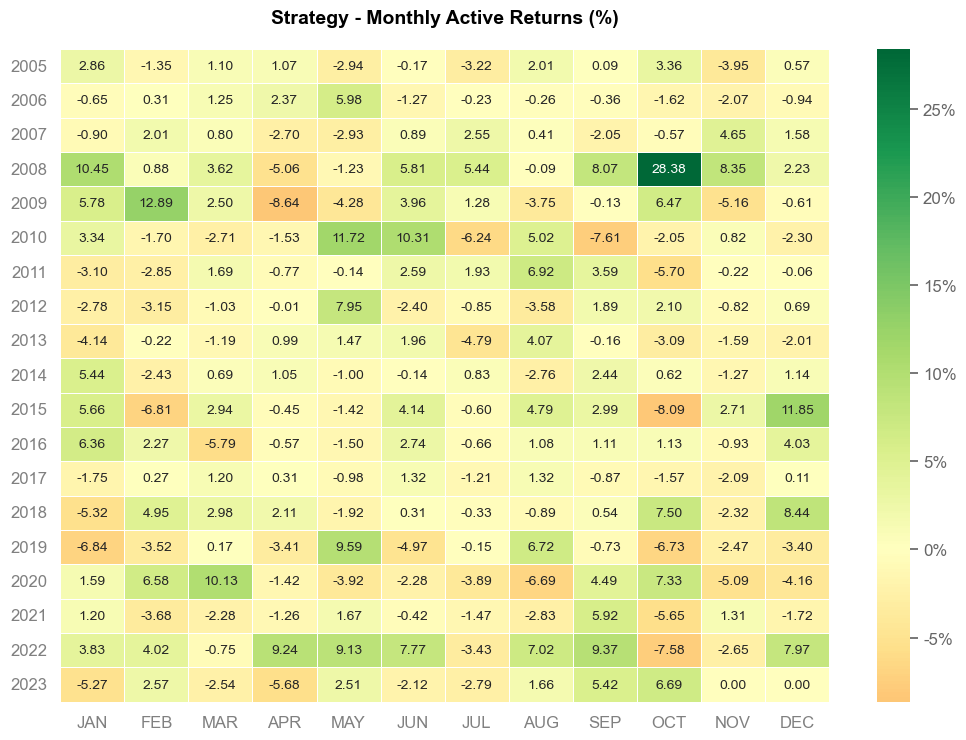

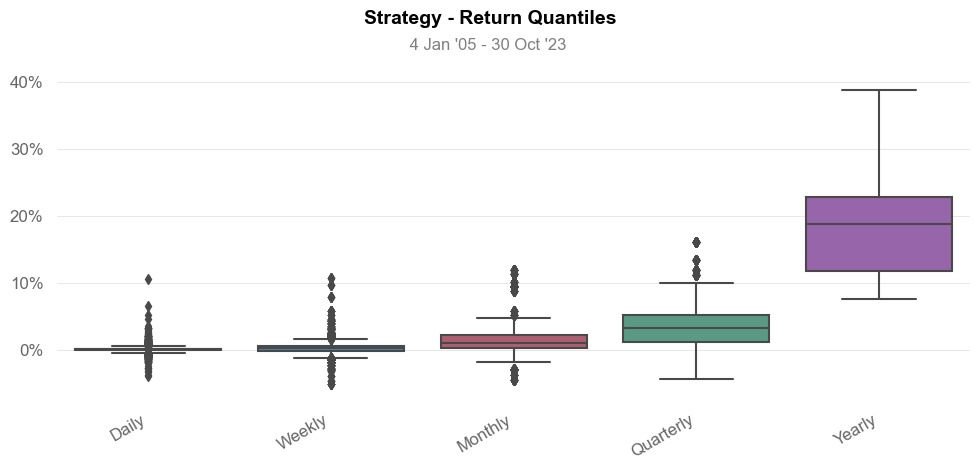

In [1380]:
qs.reports.full(daily_portfolio_return, "SPY", figsize=(10, 5))

In [1381]:
# qs.reports.html(ewp_return, 'SPY')